<a href="https://colab.research.google.com/github/jeffersonduartebr/dataset_ovos/blob/main/projeto_rna_cnn_B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyyaml h5py
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.applications import EfficientNetB0, ResNet152V2, DenseNet201, ConvNeXtXLarge, InceptionResNetV2, MobileNet
from keras.utils import load_img
from keras.utils import img_to_array
from keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds
import numpy as np
import pathlib

import matplotlib.pyplot as plt
%matplotlib inline

#os.environ["CUDA_VISIBLE_DEVICES"]="1"
policy = tf.keras.mixed_precision.Policy("mixed_float16")
tf.keras.mixed_precision.set_global_policy(policy)

In [2]:
print(os.getcwd())
#os.chdir('dataset_ovos')
path = "dataset"
isExist = os.path.exists(path)

if not isExist:
   os.makedirs(path)
   #os.chdir(path)
   !curl -L "https://app.roboflow.com/ds/t8UiiZL7No?key=L9ew2mZJt8" >> dataset/roboflow.zip ; unzip roboflow.zip; rm roboflow.zip

print(os.getcwd())

data_dir = 'dataset/train'
data_dir = pathlib.Path(data_dir)

/content
/content


In [ ]:
diretorio = 'dataset/valid'
for subdir in ['M', 'G', 'GG', 'JB']:
    subdir_path = os.path.join(diretorio, subdir)

    # List all image files in the current subdirectory
    image_paths = [os.path.join(subdir_path, filename) for filename in os.listdir(subdir_path) if filename.endswith((".jpg", ".jpeg", ".png"))]
    for image_path in image_paths:
        try:
            print('Processing: ', image_path)
            image = load_img(image_path)
            image = img_to_array(image)
            image = np.expand_dims(image, axis=0)
            # criar um gerador (generator) com as imagens do data augmentation
            imgAug = ImageDataGenerator(rotation_range=45, width_shift_range=0.2,
                                        height_shift_range=0.1, zoom_range=0.25,
                                        brightness_range=(0.1, 0.5), shear_range=0.25,
                                        fill_mode='nearest', horizontal_flip=True)

            imgGen = imgAug.flow(image, save_to_dir=subdir_path,
                                save_format='jpg', save_prefix='i_')

            # gerar 25 imagens por data augmentation
            counter = 0

            for (i, newImage) in enumerate(imgGen):
                counter += 1
                # ao gerar 10 imagens, parar o loop
                if counter == 25:
                    break
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")


diretorio = 'dataset/train'
for subdir in ['M', 'G', 'GG', 'JB']:
    subdir_path = os.path.join(diretorio, subdir)

    # List all image files in the current subdirectory
    image_paths = [os.path.join(subdir_path, filename) for filename in os.listdir(subdir_path) if filename.endswith((".jpg", ".jpeg", ".png"))]
    for image_path in image_paths:
        try:
            print('Processing: ', image_path)
            image = load_img(image_path)
            image = img_to_array(image)
            image = np.expand_dims(image, axis=0)
            # criar um gerador (generator) com as imagens do data augmentation
            imgAug = ImageDataGenerator(rotation_range=45, width_shift_range=0.2,
                                        height_shift_range=0.1, zoom_range=0.25,
                                        brightness_range=(0.1, 0.5), shear_range=0.25,
                                        fill_mode='nearest', horizontal_flip=True)

            imgGen = imgAug.flow(image, save_to_dir=subdir_path,
                                save_format='jpg', save_prefix='i_')

            # gerar 25 imagens por data augmentation
            counter = 0

            for (i, newImage) in enumerate(imgGen):
                counter += 1
                # ao gerar 10 imagens, parar o loop
                if counter == 25:
                    break
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")

In [3]:
IMG_SIZE = 224 # All images will be resized to 160x160
BATCH_SIZE = 64
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=BATCH_SIZE)

data_dir = 'dataset/valid'
data_dir = pathlib.Path(data_dir)
validation_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=BATCH_SIZE)

Found 158 files belonging to 4 classes.
Found 46 files belonging to 4 classes.


In [4]:
class_names = train_ds.class_names
print(class_names)

['G', 'GG', 'JB', 'M']


In [5]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

In [6]:
num_classes = len(class_names)
base_model = EfficientNetB0(weights='imagenet', include_top=False)
#Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer
x = Dense(256, activation='relu')(x)

# Add a logistic layer with the number of classes you have (let's say 200)
predictions = Dense(4, activation='softmax')(x)

# This is the model we will train
model = keras.Model(inputs=base_model.input, outputs=predictions)
print(len(base_model.layers))

base_model.trainable = True
# Fine-tune from this layer onwards
fine_tune_at = (len(base_model.layers) - 20)

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

238


In [7]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        7         ['rescaling_1[0][0]']         
 on)                                                                                              
                                                                                                  
 rescaling_2 (Rescaling)     (None, None, None, 3)        0         ['normalization[0][0]']   

In [8]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
if not os.path.exists("../bkp_models"):
    os.makedirs("../bkp_models")
if not os.path.exists("../models"):
    os.makedirs("../models")

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
]

In [10]:
#os.chdir('dataset_ovos/dataset')
print(os.getcwd())

history = model.fit(
  train_ds,
  verbose=1,
  validation_data=validation_ds,
  epochs=20,
  callbacks=my_callbacks
)
#wandb.finish()

/content
Epoch 1/20
3/3 [==============================] - 34s 4s/step - loss: 1.2417 - accuracy: 0.4177 - val_loss: 1.2568 - val_accuracy: 0.4130
Epoch 2/20
3/3 [==============================] - 11s 3s/step - loss: 0.5461 - accuracy: 0.8228 - val_loss: 1.2891 - val_accuracy: 0.3913
Epoch 3/20
3/3 [==============================] - 10s 1s/step - loss: 0.2823 - accuracy: 0.9177 - val_loss: 1.3320 - val_accuracy: 0.5000
Epoch 4/20
3/3 [==============================] - 9s 949ms/step - loss: 0.0953 - accuracy: 0.9810 - val_loss: 1.1074 - val_accuracy: 0.5217
Epoch 5/20
3/3 [==============================] - 11s 961ms/step - loss: 0.0479 - accuracy: 0.9937 - val_loss: 0.8252 - val_accuracy: 0.5652
Epoch 6/20
3/3 [==============================] - 9s 2s/step - loss: 0.0531 - accuracy: 0.9810 - val_loss: 0.4858 - val_accuracy: 0.7826
Epoch 7/20
3/3 [==============================] - 9s 991ms/step - loss: 0.0102 - accuracy: 1.0000 - val_loss: 0.3462 - val_accuracy: 0.8696
Epoch 8/20
3/3 [===

In [11]:
model.save('models/efficientNetB0')

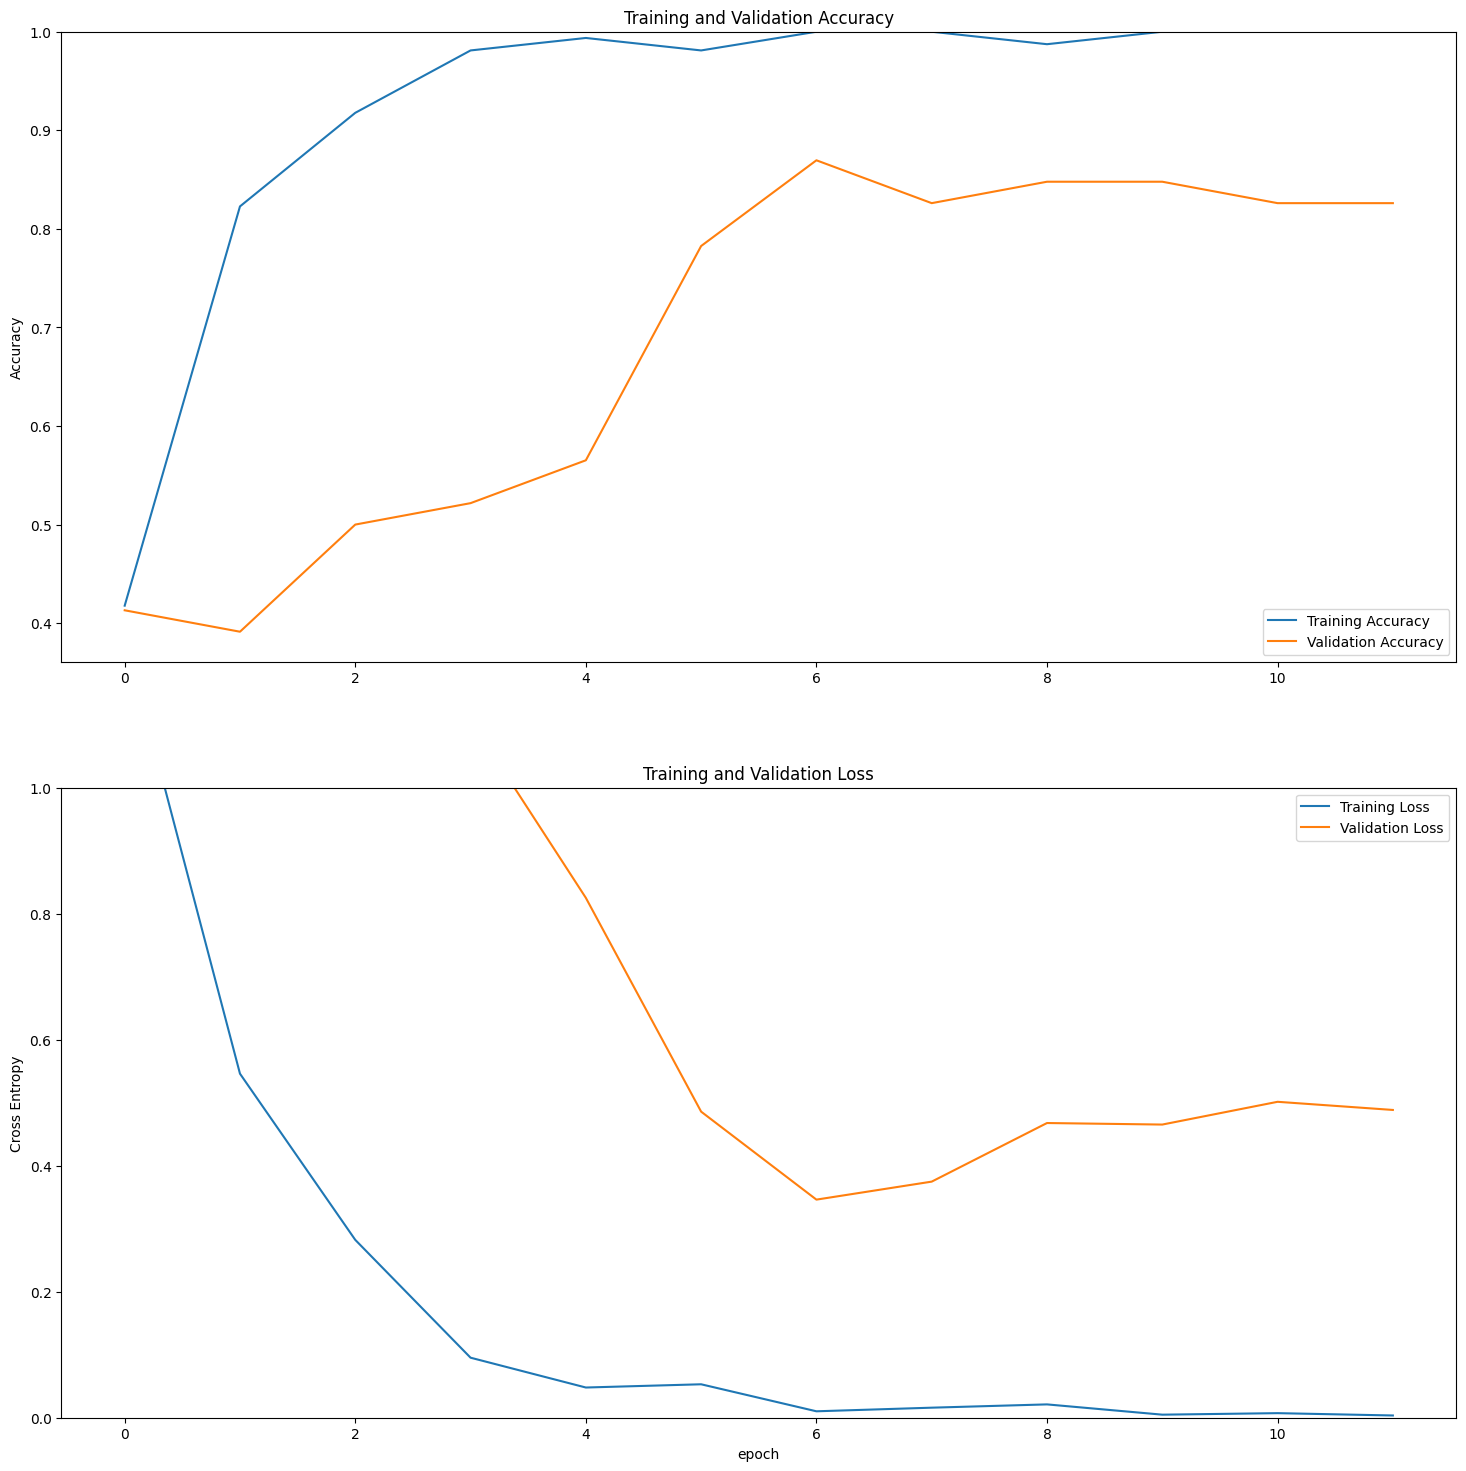

<Figure size 640x480 with 0 Axes>

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(18, 18))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
plt.savefig('train_val_acc_los_B5.png')